
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/soumendusekharbhattacharjee/anaconda3/envs/mask_rcnn/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/soumendusekharbhattacharjee/anaconda3/envs/mask_rcnn/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/Users/soumendusekharbhattacharjee/anaconda3/envs/mask_rcnn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/soumendusekharbhattacha

Using device: cpu
Loading dataset...
Found 1411 images
Train samples: 80, Val samples: 20
Testing data loading...
Error loading sample 46: Numpy is not available
Batch 0: 1 images
Error loading sample 76: Numpy is not available
Batch 1: 1 images
Error loading sample 53: Numpy is not available
Batch 2: 1 images
Loading model...
Starting training...

=== Epoch 1/1 ===


Epoch 0:   0%|                                           | 0/80 [00:00<?, ?it/s]

Error loading sample 45: Numpy is not available


Epoch 0:   1%|▍                                  | 1/80 [00:02<03:43,  2.83s/it]

Epoch: 0, Batch: 0, Loss: 2.6758
  loss_classifier: 2.6758
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 78: Numpy is not available


Epoch 0:   2%|▉                                  | 2/80 [00:07<05:15,  4.05s/it]

Error loading sample 57: Numpy is not available


Epoch 0:   4%|█▎                                 | 3/80 [00:10<04:41,  3.65s/it]

Error loading sample 47: Numpy is not available


Epoch 0:   5%|█▊                                 | 4/80 [00:14<04:35,  3.62s/it]

Error loading sample 66: Numpy is not available


Epoch 0:   6%|██▏                                | 5/80 [00:20<05:42,  4.57s/it]

Error loading sample 41: Numpy is not available


Epoch 0:   8%|██▋                                | 6/80 [01:00<20:29, 16.62s/it]

Error loading sample 22: Numpy is not available


Epoch 0:   9%|███                                | 7/80 [01:08<16:50, 13.84s/it]

Error loading sample 51: Numpy is not available


Epoch 0:  10%|███▌                               | 8/80 [01:14<13:20, 11.11s/it]

Error loading sample 70: Numpy is not available


Epoch 0:  11%|███▉                               | 9/80 [01:19<10:58,  9.27s/it]

Error loading sample 39: Numpy is not available


Epoch 0:  12%|████▎                             | 10/80 [01:23<08:53,  7.62s/it]

Error loading sample 42: Numpy is not available


Epoch 0:  14%|████▋                             | 11/80 [01:54<16:54, 14.71s/it]

Epoch: 0, Batch: 10, Loss: 1.7009
  loss_classifier: 1.7008
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0001
  loss_rpn_box_reg: 0.0000
Error loading sample 79: Numpy is not available


Epoch 0:  15%|█████                             | 12/80 [01:58<13:05, 11.56s/it]

Error loading sample 61: Numpy is not available


Epoch 0:  16%|█████▌                            | 13/80 [02:00<09:43,  8.71s/it]

Error loading sample 63: Numpy is not available


Epoch 0:  18%|█████▉                            | 14/80 [02:04<08:05,  7.36s/it]

Error loading sample 72: Numpy is not available


Epoch 0:  19%|██████▍                           | 15/80 [02:07<06:31,  6.02s/it]

Error loading sample 32: Numpy is not available


Epoch 0:  20%|██████▊                           | 16/80 [02:19<08:25,  7.90s/it]

Error loading sample 4: Numpy is not available


Epoch 0:  21%|███████▏                          | 17/80 [02:23<07:01,  6.69s/it]

Error loading sample 38: Numpy is not available


Epoch 0:  22%|███████▋                          | 18/80 [02:26<05:32,  5.36s/it]

Error loading sample 1: Numpy is not available


Epoch 0:  24%|████████                          | 19/80 [02:36<07:07,  7.00s/it]

Error loading sample 18: Numpy is not available


Epoch 0:  25%|████████▌                         | 20/80 [03:01<12:17, 12.29s/it]

Error loading sample 35: Numpy is not available


Epoch 0:  26%|████████▉                         | 21/80 [03:04<09:11,  9.35s/it]

Epoch: 0, Batch: 20, Loss: 0.3383
  loss_classifier: 0.3376
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0007
  loss_rpn_box_reg: 0.0000
Error loading sample 74: Numpy is not available


Epoch 0:  28%|█████████▎                        | 22/80 [03:16<09:50, 10.18s/it]

Error loading sample 75: Numpy is not available


Epoch 0:  29%|█████████▊                        | 23/80 [03:19<07:35,  8.00s/it]

Error loading sample 17: Numpy is not available


Epoch 0:  30%|██████████▏                       | 24/80 [03:26<07:11,  7.71s/it]

Error loading sample 15: Numpy is not available


Epoch 0:  31%|██████████▋                       | 25/80 [03:38<08:23,  9.16s/it]

Error loading sample 56: Numpy is not available


Epoch 0:  32%|███████████                       | 26/80 [04:47<24:15, 26.96s/it]

Error loading sample 77: Numpy is not available


Epoch 0:  34%|███████████▍                      | 27/80 [04:50<17:38, 19.97s/it]

Error loading sample 30: Numpy is not available


Epoch 0:  35%|███████████▉                      | 28/80 [05:07<16:24, 18.92s/it]

Error loading sample 20: Numpy is not available


Epoch 0:  36%|████████████▎                     | 29/80 [05:30<17:15, 20.31s/it]

Error loading sample 37: Numpy is not available


Epoch 0:  38%|████████████▊                     | 30/80 [05:35<13:03, 15.66s/it]

Error loading sample 43: Numpy is not available


Epoch 0:  39%|█████████████▏                    | 31/80 [05:43<10:52, 13.32s/it]

Epoch: 0, Batch: 30, Loss: 0.0155
  loss_classifier: 0.0155
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 65: Numpy is not available


Epoch 0:  40%|█████████████▌                    | 32/80 [05:46<08:11, 10.25s/it]

Error loading sample 0: Numpy is not available


Epoch 0:  41%|██████████████                    | 33/80 [06:21<13:45, 17.56s/it]

Error loading sample 14: Numpy is not available


Epoch 0:  42%|██████████████▍                   | 34/80 [06:51<16:29, 21.51s/it]

Error loading sample 33: Numpy is not available


Epoch 0:  44%|██████████████▉                   | 35/80 [07:10<15:30, 20.67s/it]

Error loading sample 55: Numpy is not available


Epoch 0:  45%|███████████████▎                  | 36/80 [07:18<12:23, 16.91s/it]

Error loading sample 31: Numpy is not available


Epoch 0:  46%|███████████████▋                  | 37/80 [07:31<11:07, 15.53s/it]

Error loading sample 7: Numpy is not available


Epoch 0:  48%|████████████████▏                 | 38/80 [08:27<19:28, 27.81s/it]

Error loading sample 25: Numpy is not available


Epoch 0:  49%|████████████████▌                 | 39/80 [08:42<16:16, 23.82s/it]

Error loading sample 69: Numpy is not available


Epoch 0:  50%|█████████████████                 | 40/80 [08:45<11:48, 17.72s/it]

Error loading sample 60: Numpy is not available


Epoch 0:  51%|█████████████████▍                | 41/80 [08:53<09:35, 14.76s/it]

Epoch: 0, Batch: 40, Loss: 0.0070
  loss_classifier: 0.0070
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 24: Numpy is not available


Epoch 0:  52%|█████████████████▊                | 42/80 [09:03<08:30, 13.44s/it]

Error loading sample 34: Numpy is not available


Epoch 0:  54%|██████████████████▎               | 43/80 [09:56<15:31, 25.18s/it]

Error loading sample 11: Numpy is not available


Epoch 0:  55%|██████████████████▋               | 44/80 [10:12<13:28, 22.45s/it]

Error loading sample 13: Numpy is not available


Epoch 0:  56%|███████████████████▏              | 45/80 [10:35<13:07, 22.51s/it]

Error loading sample 10: Numpy is not available


Epoch 0:  57%|███████████████████▌              | 46/80 [11:09<14:42, 25.96s/it]

Error loading sample 40: Numpy is not available


Epoch 0:  59%|███████████████████▉              | 47/80 [11:11<10:25, 18.96s/it]

Error loading sample 21: Numpy is not available


Epoch 0:  60%|████████████████████▍             | 48/80 [11:25<09:15, 17.37s/it]

Error loading sample 54: Numpy is not available


Epoch 0:  61%|████████████████████▊             | 49/80 [11:30<07:06, 13.76s/it]

Error loading sample 76: Numpy is not available


Epoch 0:  62%|█████████████████████▎            | 50/80 [11:47<07:17, 14.57s/it]

Error loading sample 67: Numpy is not available


Epoch 0:  64%|█████████████████████▋            | 51/80 [12:00<06:47, 14.06s/it]

Epoch: 0, Batch: 50, Loss: 0.0004
  loss_classifier: 0.0004
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 5: Numpy is not available


Epoch 0:  65%|██████████████████████            | 52/80 [12:08<05:50, 12.51s/it]

Error loading sample 12: Numpy is not available


Epoch 0:  66%|██████████████████████▌           | 53/80 [12:45<08:50, 19.64s/it]

Error loading sample 3: Numpy is not available


Epoch 0:  68%|██████████████████████▉           | 54/80 [12:48<06:25, 14.83s/it]

Error loading sample 68: Numpy is not available


Epoch 0:  69%|███████████████████████▍          | 55/80 [12:51<04:41, 11.26s/it]

Error loading sample 9: Numpy is not available


Epoch 0:  70%|███████████████████████▊          | 56/80 [12:58<03:59,  9.98s/it]

Error loading sample 6: Numpy is not available


Epoch 0:  71%|████████████████████████▏         | 57/80 [13:04<03:17,  8.61s/it]

Error loading sample 73: Numpy is not available


Epoch 0:  72%|████████████████████████▋         | 58/80 [13:08<02:40,  7.28s/it]

Error loading sample 28: Numpy is not available


Epoch 0:  74%|█████████████████████████         | 59/80 [13:12<02:12,  6.32s/it]

Error loading sample 27: Numpy is not available


Epoch 0:  75%|█████████████████████████▌        | 60/80 [13:20<02:16,  6.81s/it]

Error loading sample 2: Numpy is not available


Epoch 0:  76%|█████████████████████████▉        | 61/80 [13:29<02:20,  7.42s/it]

Epoch: 0, Batch: 60, Loss: 0.0004
  loss_classifier: 0.0004
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 53: Numpy is not available


Epoch 0:  78%|██████████████████████████▎       | 62/80 [13:32<01:49,  6.10s/it]

Error loading sample 62: Numpy is not available


Epoch 0:  79%|██████████████████████████▊       | 63/80 [13:37<01:41,  5.95s/it]

Error loading sample 50: Numpy is not available


Epoch 0:  80%|███████████████████████████▏      | 64/80 [13:41<01:26,  5.39s/it]

Error loading sample 26: Numpy is not available


Epoch 0:  81%|███████████████████████████▋      | 65/80 [13:49<01:30,  6.05s/it]

Error loading sample 58: Numpy is not available


Epoch 0:  82%|████████████████████████████      | 66/80 [14:00<01:46,  7.61s/it]

Error loading sample 49: Numpy is not available


Epoch 0:  84%|████████████████████████████▍     | 67/80 [14:03<01:19,  6.13s/it]

Error loading sample 52: Numpy is not available


Epoch 0:  85%|████████████████████████████▉     | 68/80 [14:06<01:01,  5.13s/it]

Error loading sample 29: Numpy is not available


Epoch 0:  86%|█████████████████████████████▎    | 69/80 [14:12<01:01,  5.60s/it]

Error loading sample 71: Numpy is not available


Epoch 0:  88%|█████████████████████████████▊    | 70/80 [14:16<00:48,  4.85s/it]

Error loading sample 8: Numpy is not available


Epoch 0:  89%|██████████████████████████████▏   | 71/80 [14:21<00:44,  4.96s/it]

Epoch: 0, Batch: 70, Loss: 0.0004
  loss_classifier: 0.0004
  loss_box_reg: 0.0000
  loss_mask: 0.0000
  loss_objectness: 0.0000
  loss_rpn_box_reg: 0.0000
Error loading sample 19: Numpy is not available


Epoch 0:  90%|██████████████████████████████▌   | 72/80 [14:36<01:05,  8.18s/it]

Error loading sample 16: Numpy is not available


Epoch 0:  91%|███████████████████████████████   | 73/80 [14:48<01:04,  9.19s/it]

Error loading sample 36: Numpy is not available


Epoch 0:  92%|███████████████████████████████▍  | 74/80 [14:52<00:45,  7.63s/it]

Error loading sample 48: Numpy is not available


Epoch 0:  94%|███████████████████████████████▉  | 75/80 [14:56<00:32,  6.55s/it]

Error loading sample 59: Numpy is not available


Epoch 0:  95%|████████████████████████████████▎ | 76/80 [15:02<00:25,  6.39s/it]

Error loading sample 46: Numpy is not available


Epoch 0:  96%|████████████████████████████████▋ | 77/80 [15:05<00:16,  5.51s/it]

Error loading sample 44: Numpy is not available


Epoch 0:  98%|█████████████████████████████████▏| 78/80 [15:36<00:26, 13.09s/it]

Error loading sample 64: Numpy is not available


Epoch 0:  99%|█████████████████████████████████▌| 79/80 [15:48<00:12, 12.66s/it]

Error loading sample 23: Numpy is not available


Evaluating:   0%|                                        | 0/20 [00:00<?, ?it/s]

Error loading sample 80: Numpy is not available


Evaluating:   5%|█▌                              | 1/20 [00:20<06:28, 20.43s/it]

Error in evaluation batch 0: 'list' object has no attribute 'values'
Error loading sample 81: Numpy is not available


Evaluating:  10%|███▏                            | 2/20 [00:56<08:54, 29.68s/it]

Error in evaluation batch 1: 'list' object has no attribute 'values'
Error loading sample 82: Numpy is not available


Evaluating:  15%|████▊                           | 3/20 [01:01<05:14, 18.51s/it]

Error in evaluation batch 2: 'list' object has no attribute 'values'
Error loading sample 83: Numpy is not available


Evaluating:  20%|██████▍                         | 4/20 [01:09<03:47, 14.21s/it]

Error in evaluation batch 3: 'list' object has no attribute 'values'
Error loading sample 84: Numpy is not available


Evaluating:  25%|████████                        | 5/20 [01:14<02:42, 10.87s/it]

Error in evaluation batch 4: 'list' object has no attribute 'values'
Error loading sample 85: Numpy is not available


Evaluating:  30%|█████████▌                      | 6/20 [01:15<01:46,  7.59s/it]

Error in evaluation batch 5: 'list' object has no attribute 'values'
Error loading sample 86: Numpy is not available


Evaluating:  35%|███████████▏                    | 7/20 [01:20<01:28,  6.79s/it]

Error in evaluation batch 6: 'list' object has no attribute 'values'
Error loading sample 87: Numpy is not available


Evaluating:  40%|████████████▊                   | 8/20 [01:36<01:57,  9.79s/it]

Error in evaluation batch 7: 'list' object has no attribute 'values'
Error loading sample 88: Numpy is not available


Evaluating:  45%|██████████████▍                 | 9/20 [01:41<01:31,  8.30s/it]

Error in evaluation batch 8: 'list' object has no attribute 'values'
Error loading sample 89: Numpy is not available


Evaluating:  50%|███████████████▌               | 10/20 [01:47<01:14,  7.47s/it]

Error in evaluation batch 9: 'list' object has no attribute 'values'
Error loading sample 90: Numpy is not available


Evaluating:  55%|█████████████████              | 11/20 [01:52<01:00,  6.67s/it]

Error in evaluation batch 10: 'list' object has no attribute 'values'
Error loading sample 91: Numpy is not available


Evaluating:  60%|██████████████████▌            | 12/20 [01:54<00:42,  5.26s/it]

Error in evaluation batch 11: 'list' object has no attribute 'values'
Error loading sample 92: Numpy is not available


Evaluating:  65%|████████████████████▏          | 13/20 [01:57<00:31,  4.53s/it]

Error in evaluation batch 12: 'list' object has no attribute 'values'
Error loading sample 93: Numpy is not available


Evaluating:  70%|█████████████████████▋         | 14/20 [01:59<00:23,  3.90s/it]

Error in evaluation batch 13: 'list' object has no attribute 'values'
Error loading sample 94: Numpy is not available


Evaluating:  75%|███████████████████████▎       | 15/20 [02:01<00:16,  3.25s/it]

Error in evaluation batch 14: 'list' object has no attribute 'values'
Error loading sample 95: Numpy is not available


Evaluating:  80%|████████████████████████▊      | 16/20 [02:03<00:10,  2.73s/it]

Error in evaluation batch 15: 'list' object has no attribute 'values'
Error loading sample 96: Numpy is not available


Evaluating:  85%|██████████████████████████▎    | 17/20 [02:05<00:07,  2.59s/it]

Error in evaluation batch 16: 'list' object has no attribute 'values'
Error loading sample 97: Numpy is not available


Evaluating:  90%|███████████████████████████▉   | 18/20 [02:15<00:09,  4.73s/it]

Error in evaluation batch 17: 'list' object has no attribute 'values'
Error loading sample 98: Numpy is not available


Evaluating:  95%|█████████████████████████████▍ | 19/20 [02:19<00:04,  4.72s/it]

Error in evaluation batch 18: 'list' object has no attribute 'values'
Error loading sample 99: Numpy is not available


Evaluating: 100%|███████████████████████████████| 20/20 [02:21<00:00,  7.07s/it]

Error in evaluation batch 19: 'list' object has no attribute 'values'
Epoch 1: Train Loss: 0.4474, Val Loss: 0.0000
Learning Rate: 0.001000


Checkpoint saved: maskrcnn_epoch_0.pth


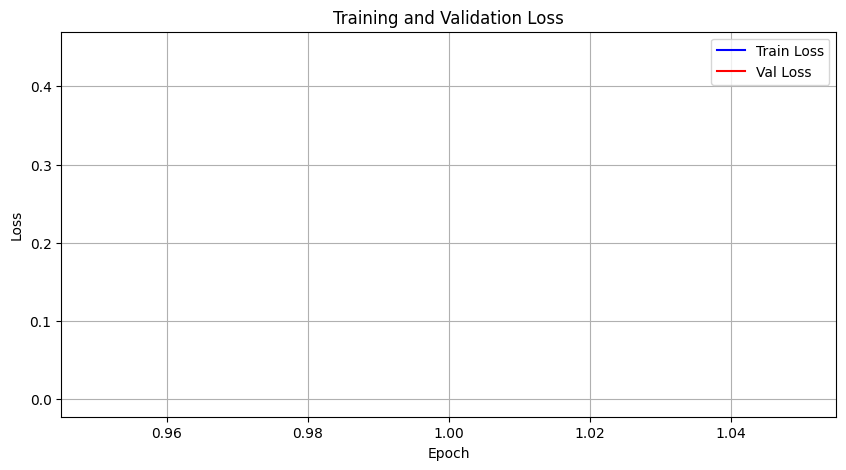

Training completed successfully!


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import numpy as np
from PIL import Image
import json
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


class iSAIDDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        iSAID Dataset for Mask R-CNN training
        
        Args:
            root_dir: Path to the iSAID train directory
            transforms: Optional transforms to apply
        """
        self.root_dir = Path(root_dir)
        self.transforms = transforms
        
        # Paths to different directories
        self.annotations_dir = self.root_dir / "Annotations"
        self.instance_masks_dir = self.root_dir / "Instance_masks" / "images"
        self.semantic_masks_dir = self.root_dir / "Semantic_masks" / "images"
        
        # Check if directories exist
        if not self.instance_masks_dir.exists():
            raise ValueError(f"Instance masks directory not found: {self.instance_masks_dir}")
        if not self.semantic_masks_dir.exists():
            raise ValueError(f"Semantic masks directory not found: {self.semantic_masks_dir}")
        
        # Get all image files
        self.image_files = sorted([f for f in os.listdir(self.instance_masks_dir) 
                                 if f.endswith('.png')])
        
        print(f"Found {len(self.image_files)} images")
        
        # iSAID class mapping (15 classes + background)
        self.classes = [
            'background', 'ship', 'storage_tank', 'baseball_diamond', 
            'tennis_court', 'basketball_court', 'ground_track_field',
            'bridge', 'large_vehicle', 'small_vehicle', 'helicopter',
            'swimming_pool', 'roundabout', 'soccer_ball_field', 
            'plane', 'harbor'
        ]
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Create RGB to class mapping for iSAID semantic masks
        self.rgb_to_class = self.create_rgb_mapping()
        
    def create_rgb_mapping(self):
        """Create RGB to class index mapping for iSAID"""
        # iSAID typically uses specific RGB values for each class
        # You may need to adjust these based on your actual semantic mask colors
        rgb_mapping = {
            (0, 0, 0): 0,        # background
            (0, 0, 63): 1,       # ship
            (0, 63, 63): 2,      # storage_tank
            (0, 63, 0): 3,       # baseball_diamond
            (0, 63, 127): 4,     # tennis_court
            (0, 63, 191): 5,     # basketball_court
            (0, 63, 255): 6,     # ground_track_field
            (0, 127, 63): 7,     # bridge
            (0, 127, 127): 8,    # large_vehicle
            (0, 0, 127): 9,      # small_vehicle
            (0, 0, 191): 10,     # helicopter
            (0, 0, 255): 11,     # swimming_pool
            (0, 191, 127): 12,   # roundabout
            (0, 127, 191): 13,   # soccer_ball_field
            (0, 127, 255): 14,   # plane
            (0, 100, 155): 15,   # harbor
        }
        return rgb_mapping
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        try:
            # Get image filename
            img_filename = self.image_files[idx]
            base_name = img_filename.replace('_instance_id_RGB.png', '')
            
            # Create a dummy RGB image since we don't have original images
            # In practice, you should load the actual RGB image here
            img = Image.new('RGB', (800, 800), color=(128, 128, 128))
            
            # Load instance mask
            instance_mask_path = self.instance_masks_dir / img_filename
            if not instance_mask_path.exists():
                raise FileNotFoundError(f"Instance mask not found: {instance_mask_path}")
                
            instance_mask = np.array(Image.open(instance_mask_path))
            
            # Load semantic mask
            semantic_filename = img_filename.replace('_instance_id_RGB.png', '_instance_color_RGB.png')
            semantic_mask_path = self.semantic_masks_dir / semantic_filename
            
            if not semantic_mask_path.exists():
                raise FileNotFoundError(f"Semantic mask not found: {semantic_mask_path}")
                
            semantic_mask = np.array(Image.open(semantic_mask_path))
            
            # Resize image to match mask dimensions
            mask_height, mask_width = instance_mask.shape[:2]
            img = img.resize((mask_width, mask_height))
            
            # Extract individual instances from masks
            boxes, labels, masks = self.extract_instances(instance_mask, semantic_mask)
            
            # Handle empty detections
            if len(boxes) == 0:
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
                masks = torch.zeros((0, mask_height, mask_width), dtype=torch.uint8)
                area = torch.zeros((0,), dtype=torch.float32)
                iscrowd = torch.zeros((0,), dtype=torch.int64)
            else:
                # Convert to tensors
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)
                masks = torch.as_tensor(masks, dtype=torch.uint8)
                area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
                iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
            
            image_id = torch.tensor([idx])
            
            target = {
                "boxes": boxes,
                "labels": labels,
                "masks": masks,
                "image_id": image_id,
                "area": area,
                "iscrowd": iscrowd
            }
            
            if self.transforms:
                img = self.transforms(img)
            else:
                img = transforms.ToTensor()(img)
                
            return img, target
            
        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            # Return a dummy sample in case of error
            dummy_img = torch.zeros((3, 800, 800), dtype=torch.float32)
            dummy_target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
                "masks": torch.zeros((0, 800, 800), dtype=torch.uint8),
                "image_id": torch.tensor([idx]),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64)
            }
            return dummy_img, dummy_target
    
    def extract_instances(self, instance_mask, semantic_mask):
        """Extract individual instances from masks"""
        try:
            # Handle different mask dimensions
            if len(instance_mask.shape) == 3:
                # If RGB, convert to grayscale by taking one channel
                instance_mask = instance_mask[:, :, 0]
            
            # Get unique instance IDs (excluding background)
            unique_instances = np.unique(instance_mask)
            unique_instances = unique_instances[unique_instances > 0]  # Remove background
            
            boxes = []
            labels = []
            masks = []
            
            for instance_id in unique_instances:
                # Create binary mask for this instance
                instance_binary_mask = (instance_mask == instance_id).astype(np.uint8)
                
                # Skip if mask is too small
                if np.sum(instance_binary_mask) < 100:  # Increased threshold
                    continue
                    
                # Get bounding box
                pos = np.where(instance_binary_mask)
                if len(pos[0]) == 0:
                    continue
                    
                xmin = int(np.min(pos[1]))
                xmax = int(np.max(pos[1]))
                ymin = int(np.min(pos[0]))
                ymax = int(np.max(pos[0]))
                
                # Skip invalid boxes
                if xmax <= xmin or ymax <= ymin or (xmax - xmin) < 5 or (ymax - ymin) < 5:
                    continue
                
                boxes.append([xmin, ymin, xmax, ymax])
                
                # Get class label from semantic mask
                class_label = self.get_class_from_semantic_mask(semantic_mask, instance_binary_mask)
                labels.append(class_label)
                masks.append(instance_binary_mask)
            
            return boxes, labels, masks
            
        except Exception as e:
            print(f"Error extracting instances: {str(e)}")
            return [], [], []
    
    def get_class_from_semantic_mask(self, semantic_mask, instance_mask):
        """Get class label from semantic mask for a specific instance"""
        try:
            # Get the region corresponding to this instance
            masked_semantic = semantic_mask[instance_mask > 0]
            
            if len(masked_semantic) == 0:
                return 1  # Default class
            
            # If semantic mask is RGB, get the most common RGB value
            if len(semantic_mask.shape) == 3:
                # Reshape to get RGB values
                rgb_values = masked_semantic.reshape(-1, 3)
                
                # Find most common RGB value
                unique_colors, counts = np.unique(rgb_values, axis=0, return_counts=True)
                most_common_color = tuple(unique_colors[np.argmax(counts)])
                
                # Map to class index
                return self.rgb_to_class.get(most_common_color, 1)
            else:
                # If grayscale, use the most common value directly
                unique_values, counts = np.unique(masked_semantic, return_counts=True)
                most_common_value = unique_values[np.argmax(counts)]
                return min(int(most_common_value), 15)  # Clamp to valid class range
                
        except Exception as e:
            print(f"Error getting class from semantic mask: {str(e)}")
            return 1  # Default class


def get_model(num_classes):
    """Create Mask R-CNN model"""
    # Load pre-trained model
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # Replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model


def collate_fn(batch):
    """Custom collate function for DataLoader"""
    # Filter out None values
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return [], []
    return tuple(zip(*batch))


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        try:
            if len(images) == 0:
                continue
                
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Check for invalid loss
            if torch.isnan(losses) or torch.isinf(losses):
                print(f"Invalid loss detected, skipping batch {i}")
                continue
            
            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += losses.item()
            num_batches += 1
            
            if i % print_freq == 0:
                print(f"Epoch: {epoch}, Batch: {i}, Loss: {losses.item():.4f}")
                for k, v in loss_dict.items():
                    print(f"  {k}: {v.item():.4f}")
                    
        except Exception as e:
            print(f"Error in batch {i}: {str(e)}")
            continue
    
    return running_loss / max(num_batches, 1)


def evaluate(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(tqdm(data_loader, desc="Evaluating")):
            try:
                if len(images) == 0:
                    continue
                    
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                if not (torch.isnan(losses) or torch.isinf(losses)):
                    total_loss += losses.item()
                    num_batches += 1
                    
            except Exception as e:
                print(f"Error in evaluation batch {i}: {str(e)}")
                continue
    
    return total_loss / max(num_batches, 1)


def main():
    # Configuration
    config = {
        'data_dir': '/Users/soumendusekharbhattacharjee/Downloads/iSAID_data/train',
        'batch_size': 1,  # Reduced batch size for stability
        'num_epochs': 1,  # Reduced for testing
        'learning_rate': 0.001,  # Reduced learning rate
        'weight_decay': 0.0005,
        'num_workers': 0,  # Set to 0 to avoid multiprocessing issues
        'save_dir': './checkpoints',
        'num_classes': 16  # 15 classes + background
    }
    
    # Create save directory
    os.makedirs(config['save_dir'], exist_ok=True)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    try:
        # Dataset and DataLoader
        print("Loading dataset...")
        dataset = iSAIDDataset(config['data_dir'], transforms=transform)
        
        if len(dataset) == 0:
            raise ValueError("No valid samples found in dataset")
        
        # Split dataset (use a smaller subset for testing)
        total_size = min(len(dataset), 100)  # Limit to 100 samples for testing
        train_size = int(0.8 * total_size)
        val_size = total_size - train_size
        
        # Use subset for faster testing
        indices = list(range(total_size))
        train_indices = indices[:train_size]
        val_indices = indices[train_size:total_size]
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
            collate_fn=collate_fn,
            pin_memory=True if device.type == 'cuda' else False
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers'],
            collate_fn=collate_fn,
            pin_memory=True if device.type == 'cuda' else False
        )
        
        # Test data loading
        print("Testing data loading...")
        for i, (images, targets) in enumerate(train_loader):
            print(f"Batch {i}: {len(images)} images")
            if i >= 2:  # Test first few batches
                break
        
        # Model
        print("Loading model...")
        model = get_model(config['num_classes'])
        model.to(device)
        
        # Optimizer
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(params, lr=config['learning_rate'], 
                             momentum=0.9, weight_decay=config['weight_decay'])
        
        # Learning rate scheduler
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
        
        print("Starting training...")
        
        # Training loop
        train_losses = []
        val_losses = []
        
        for epoch in range(config['num_epochs']):
            print(f"\n=== Epoch {epoch+1}/{config['num_epochs']} ===")
            
            # Train
            train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
            train_losses.append(train_loss)
            
            # Validate
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            
            # Update learning rate
            lr_scheduler.step()
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            
            # Save checkpoint
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }
            torch.save(checkpoint, f"{config['save_dir']}/maskrcnn_epoch_{epoch}.pth")
            print(f"Checkpoint saved: maskrcnn_epoch_{epoch}.pth")
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Train Loss')
        plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.grid(True)
        plt.savefig(f"{config['save_dir']}/training_curves.png")
        plt.show()
        
        print("Training completed successfully!")
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()